# Compute meridional heat transport

This notebook shows how to compute meridional heat transport (MHT) across any particular latitude band. 
Additionally, we show this for both global and basin specific cases. 

Oceanographic computations:
- use [xgcm](https://github.com/xgcm/xgcm) to compute masks and grab values at a particular latitude band
- use [ecco_v4_py](https://github.com/ECCO-GROUP/ECCOv4-py) to select a specific basin
- compute meridional heat transport at one or more latitude bands

Python basics on display:
- how to [open a dataset using xarray](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) (a one liner!)
- how to [save a dataset using xarray](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html) (another one liner!)
- how to make subplots 
- some tricks for plotting quantities defined as [dask arrays](http://docs.dask.org/en/latest/array.html)

Note that each of these tasks can be accomplished more succinctly with [ecco_v4_py](https://github.com/ECCO-GROUP/ECCOv4-py) functions, but are shown explicitly to illustrate these tools. 
Throughout, we will note the ecco_v4_py (python) and [gcmfaces](https://github.com/ECCO-GROUP/gcmfaces) (MATLAB) functions which can perform these computations.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy as cart

import ecco_v4_py as ecco
import pickle

## Load the diagnostic output 

Because we're computing transport, we want the files containing 'UVELMASS' and 'VVELMASS' for volumetric transport, and 'ADVx_TH', 'ADVy_TH' and 'DFxE_TH', 'DFyE_TH' for the advective and diffusive components of heat transport, respectively. 

In [3]:
communitydir='/work/projects/aci/ECCO/community'

nc_load_dir = f'{communitydir}/ECCO/ECCOv4/Release3p1/eccov4r3_native_grid_netcdf/mon_mean'
pickle_dir = f'{communitydir}/ECCO/ECCOv4/Release3p1/eccov4r3_native_grid_pickles'
nc_grid = f'{communitydir}/ECCO/ECCOv4/Release3p1/eccov4r3_native_grid_netcdf/grid/ECCOv4r3_grid_with_masks.nc'

In [4]:
ds = pickle.load(open(f'{pickle_dir}/mon_mean.pickle','rb'))
g = xr.open_dataset(nc_grid)
ds = xr.merge((ds,g))

In [5]:
ds

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, nv: 2, tile: 13, time: 288)
Coordinates:
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * tile       (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC         (tile, j, i) float32 -111.60647 -111.303 ... -111.86579
    YC         (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    XG    

## Grab latitude band: 26$^\circ$N array as an example

Here we want to grab the transport values which along the band closest represented in the model to 26$^\circ$N. 
In a latitude longitude grid this could simply be done by, e.g. `U.sel(lat=26)`. 
However, the LLC grid is slightly more complicated. 
Luckily, the functionality enabled by the [xgcm Grid object](https://xgcm.readthedocs.io/en/latest/api.html#grid) makes this relatively easy. 

Note that this subsection can be performed with the with the ecco_v4_py modules [vector_calc](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/vector_calc.py) and [scalar_calc](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/scalar_calc.py) as follows:

```
from ecco_v4_py import vector_calc, scalar_calc
grid = ecco_v4_py.get_llc_grid(ds)
rapid_maskW, rapid_maskS = vector_calc.get_latitude_masks(lat_val=26,yc=ds.YC,grid=grid)
rapid_maskC = scalar_calc.get_latitude_mask(lat_val=26,yc=ds.YC,grid=grid)
```

One can also use the gcmfaces function [gcmfaces_calc/gcmfaces_lines_zonal.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_zonal.m).

In [6]:
# Get array of 1's at and north of latitude
lat = 26
ones = xr.ones_like(ds.YC)
dome_maskC = ones.where(ds.YC>=lat,0)

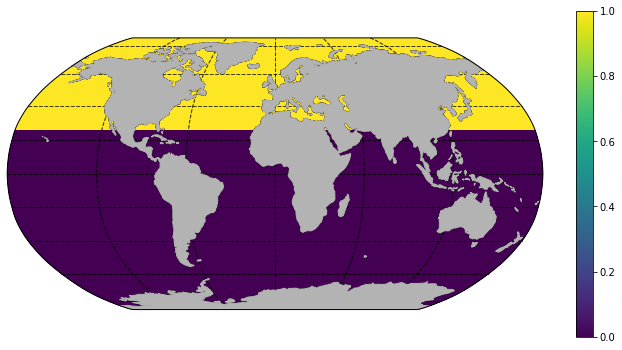

In [7]:
plt.figure(figsize=(12,6))
fig,ax,p,cb=ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,dome_maskC,
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
plt.show()

Again, if this were a lat/lon grid we could simply take a finite difference in the meridional direction. 
The only grid cells with 1's remaining would be at the southern edge of grid cells at approximately 26$^\circ$N.

However, recall that the LLC grid has a different picture.

<Figure size 864x432 with 0 Axes>

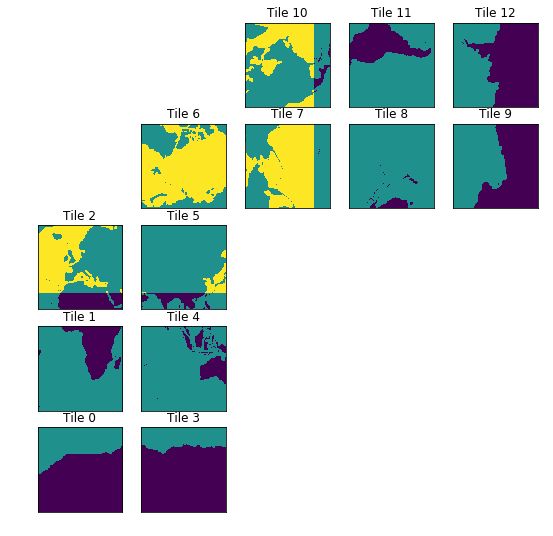

In [8]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(dome_maskC+ds['maskC'].isel(k=0), cmap='viridis')
plt.show()

Recall that for tiles 7-12, the y-dimension actually runs East-West. 
Therefore, we want to compute a finite difference in the x-dimension on these tiles to get the latitude band at 26$^\circ$N. 
For tiles 1-5, we clearly want to difference in the y-dimension. 
Things get more complicated on tile 6.

Here we make the [xgcm Grid object](https://xgcm.readthedocs.io/en/latest/api.html#grid) which allows us to compute finite differences in simple one liners. 
This object understands how each of the tiles on the LLC grid connect, because we provide that information. 
To see under the hood, checkout the utility function [get_llc_grid](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/ecco_utils.py) where these connections are defined. 

In [9]:
grid = ecco.get_llc_grid(ds)

In [10]:
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')

<Figure size 864x432 with 0 Axes>

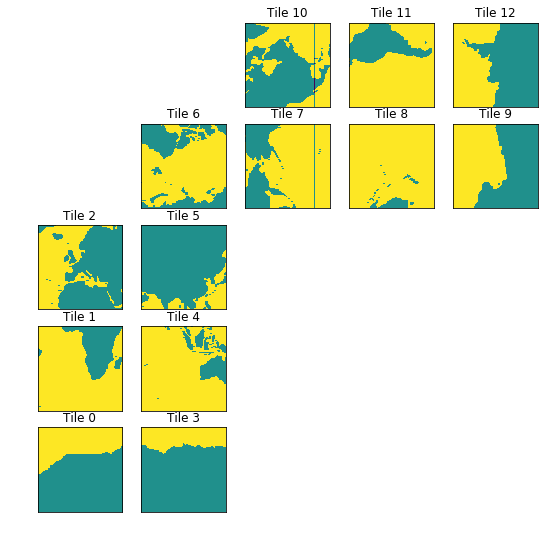

In [11]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(lat_maskW+ds['maskW'].isel(k=0), cmap='viridis')
plt.show()

<Figure size 864x432 with 0 Axes>

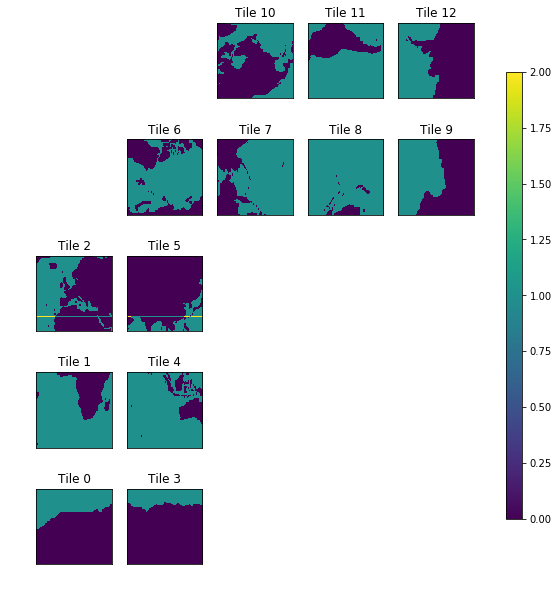

In [12]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(lat_maskS+ds['maskS'].isel(k=0), cmap='viridis',show_colorbar=True)
plt.show()

## Select the Atlantic ocean basin for RAPID-MOCHA MHT

Now that we have 26$^\circ$N we just need to select the Atlantic. 
This can be done with the [ecco_v4_py.get_basin](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py) module, specifically `ecco_v4_py.get_basin.get_basin_mask`.
Note that this function requires a mask as an input, and then returns the values within a particular ocean basin.
Therefore, provide the function with `ds['maskC']` for a mask at tracer points, `ds['maskW']` for west grid cell edges, etc.

Note: this mirrors the gcmfaces functionality [ecco_v4/v4_basin.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/ecco_v4/v4_basin.m). 

Here we just want the Atlantic ocean, but lets look at what options we have ...

In [13]:
print(ecco.get_available_basin_names())

['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents']


Notice that, for instance, 'mexico' exists separately from the Atlantic ('atl'). 
This is to provide as fine granularity as possible (and sensible). 
To grab the broader Atlantic ocean basin, i.e. the one people usually refer to, use the option 'atlExt'. 
Similar options exist for the Pacific and Indian ocean basins.

In [14]:
atl_maskW = ecco.get_basin_mask(basin_name='atlExt',mask=ds['maskW'].isel(k=0))
atl_maskS = ecco.get_basin_mask(basin_name='atlExt',mask=ds['maskS'].isel(k=0))

Notice that we pass the routine a 2D mask by selecting the first depth level. This is simply to make things run faster.

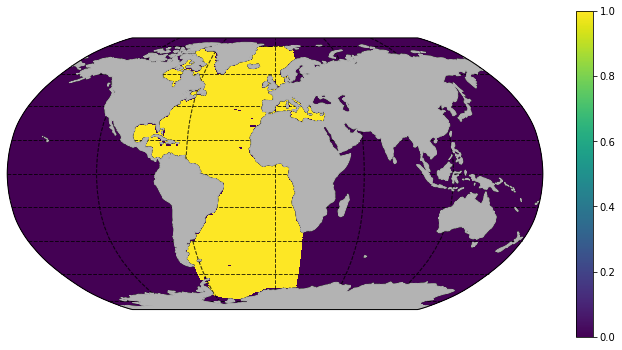

In [15]:
plt.figure(figsize=(12,6))
fig,ax,p,cb=ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,atl_maskW,
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
plt.show()

## MHT at the approximate RAPID array latitude

This can be done with the [ecco_v4_py.calc_meridional_trsp](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_meridional_trsp.py) module for heat, salt, and volume transport as follows:

```
mvt = ecco_v4_py.calc_meridional_vol_trsp(ds,lat_vals=26,basin_name='atlExt')
mht = ecco_v4_py.calc_meridional_heat_trsp(ds,lat_vals=26,basin_name='atlExt')
mst = ecco_v4_py.calc_meridional_salt_trsp(ds,lat_vals=26,basin_name='atlExt')
```

Additionally, one could compute the overturning streamfunction at this latitude band with `ecco_v4_py.calc_meridional_stf`. 
The inputs are the same as the functions above, see the module [ecco_v4_py.calc_stf](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_stf.py).

In MATLAB, one can use the functions: 
- compute meridional transports: [gcmfaces_calc/calc_MeridionalTransport.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_MeridionalTransport.m)
- compute the overturning streamfunction: [gcmfaces_calc/calc_overturn.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_overturn.m)



### A note about computational performance

When we originally open the dataset with all of the variables, we don't actually load anything into memory. In fact, nothing actually happens until "the last minute". 
For example, the data are only loaded once we do any computation like compute a mean value, plot something, or explicitly provide a `load` command for either the entire dataset or an individual DataArray within the dataset. 
This 'lazy execution' is enabled by the data structure underlying the xarray Datasets and DataArrays, the [dask array](https://docs.dask.org/en/latest/array.html). 

In short, the when the data are opened, dask builds an execution task graph which it saves up to execute at the last minute. 
Dask also allows for parallelism, and by default runs in parallel across [threads for a single core architecture](https://docs.dask.org/en/latest/scheduling.html#local-threads). 
For now, this is what we will show. 

Some quick tips are: 
- Don't load the full 25 years of ECCOv4r3 output unless you're on a machine with plenty of memory. I am doing this in the cell below because I'm on a Skylake node with 192GB. Proceed with caution before copying and pasting.
- If you're in this situation where you can't load all months into memory, it's a good idea to load 
  a final result before plotting, in case you need to plot it many times in a row, see below...

In [16]:
%%time
ds['ADVx_TH'].load();
ds['DFxE_TH'].load();
ds['ADVy_TH'].load();
ds['DFyE_TH'].load();
ds['maskC'].load();
ds['maskW'].load();
ds['maskS'].load();
ds['dxG'].load();
ds['dyG'].load();
ds['drF'].load();

CPU times: user 18.3 s, sys: 40 s, total: 58.3 s
Wall time: 4min 55s


In [17]:
%%time
trsp_x = (ds['ADVx_TH'] + ds['DFxE_TH']) * lat_maskW * atl_maskW
trsp_y = (ds['ADVy_TH'] + ds['DFyE_TH']) * lat_maskS * atl_maskS

# Sum horizontally 
trsp_x = trsp_x.sum(dim=['i_g','j','tile'])
trsp_y = trsp_y.sum(dim=['i','j_g','tile'])

# Add together to get transport at depth level 
trsp_at_depth = trsp_x + trsp_y

# Sum over full depth and convert to PW
mht = (trsp_at_depth *10**-15 * 1000 * 4000).sum('k')
mht.attrs['units']='PW'

CPU times: user 27.8 s, sys: 4.47 s, total: 32.3 s
Wall time: 32.3 s


#### Now that we have computed MHT, lets load the result for iterative plotting

For some reason when dask arrays are plotted, they are computed on the spot but don't stay in memory.
This takes a bit to get the hang of, but keep in mind that this allows us to scale the same code on distributed architecture, so we could use these same routines for high resolution output. This seems worthwhile!

Note that we probably don't need this load statement if we have already loaded the underlying datasets.

In [18]:
mht.load();

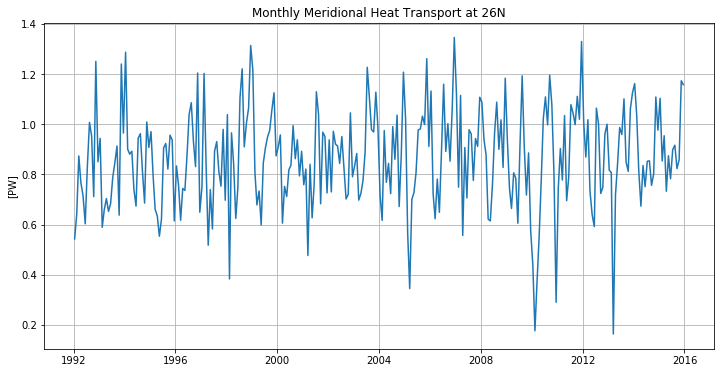

In [19]:
plt.figure(figsize=(12,6))
plt.plot(mht['time'],mht)
plt.grid()
plt.title('Monthly Meridional Heat Transport at 26N')
plt.ylabel(f'[{mht.attrs["units"]}]')
plt.show()

## Now compare global, Atlantic, Indian, and Pacific at many latitudes

In [20]:
nc_save_dir = '/work/03754/tsmith/ncfiles'
if not os.path.isdir(nc_save_dir):
    os.makedirs(nc_save_dir)

In [21]:
nc_file = f'{nc_save_dir}/eccov4r3_mht.nc'
if os.path.isfile(nc_file):
    mht = xr.open_dataset(nc_file)
else:
    global_lats = np.arange(-60,60)
    mht = ecco.calc_meridional_heat_trsp(ds, lat_vals=global_lats)
    mht = mht.rename({'heat_trsp':'global_heat_trsp'})
    mht = mht.rename({'heat_trsp_z':'global_heat_trsp_z'})
    print(' --- Done with global --- ')
    
    basin_lats = np.arange(-35,60)
    atl = ecco.calc_meridional_heat_trsp(ds,lat_vals=basin_lats,basin_name='atlExt')
    atl = atl.rename({'heat_trsp':'atl_heat_trsp'})
    atl = atl.rename({'heat_trsp_z':'atl_heat_trsp_z'})
    mht = xr.merge((mht,atl))
    print(' --- Done with Atlantic --- ')
    
    # Save results
    mht.to_netcdf(nc_file)

In [22]:
print(mht)

<xarray.Dataset>
Dimensions:             (k: 50, lat: 120, time: 288)
Coordinates:
  * lat                 (lat) int64 -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59
  * time                (time) datetime64[ns] 1992-01-16T12:00:00 ... 2015-12-16T12:00:00
  * k                   (k) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
    PHrefC              (k) float32 ...
    drF                 (k) float32 ...
    Z                   (k) float32 ...
Data variables:
    global_heat_trsp_z  (time, k, lat) float64 ...
    global_heat_trsp    (time, lat) float64 ...
    atl_heat_trsp_z     (time, k, lat) float64 ...
    atl_heat_trsp       (time, lat) float64 ...


In [23]:
mht.load();

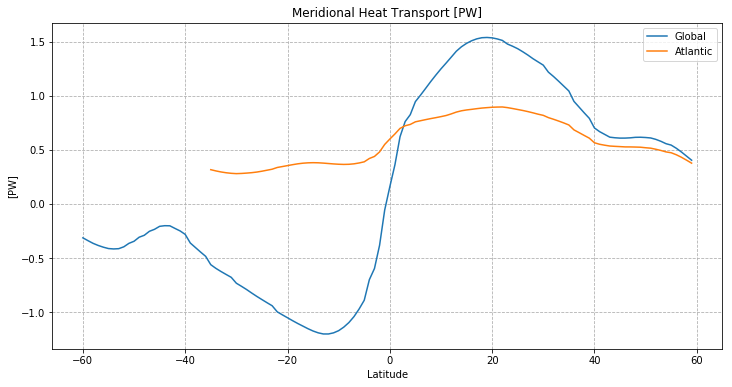

In [24]:
plt.figure(figsize=(12,6))
plt.plot(mht['lat'], mht['global_heat_trsp'].mean('time'))
plt.plot(mht['lat'], mht['atl_heat_trsp'].mean('time'))
plt.legend(('Global','Atlantic'))
plt.grid(linestyle='--')
plt.title(f'Meridional Heat Transport [{mht["global_heat_trsp"].attrs["units"]}]')
plt.ylabel(f'[{mht["global_heat_trsp"].attrs["units"]}]')
plt.xlabel('Latitude')
plt.show()

## MHT as a function of depth


In [25]:
def lat_depth_plot(mht,fld,label):
    fig = plt.figure(figsize=(12,6))
    
    # Set up depth coordinate
    depth = -mht['Z']
    stretch_depth = 200
    
    # Set up colormap and colorbar
    cmap = 'RdBu_r'
    fld_mean = mht[fld].mean('time')
    abs_max = np.max(np.abs([fld_mean.min(),fld_mean.max()]))
    cmin = -abs_max
    cmax = abs_max
    
    # First top 500m
    ax1 = plt.subplot(2,1,1)
    p1 = ax1.pcolormesh(mht['lat'],depth,fld_mean,cmap=cmap,vmin=cmin,vmax=cmax)

    # Handle y-axis
    ax1.invert_yaxis()
    plt.ylim([stretch_depth, 0])
    ax1.yaxis.axes.set_yticks(np.arange(stretch_depth,0,-50))
    plt.ylabel(f'Depth [{mht["Z"].attrs["units"]}]')

    # Remove top plot xtick label
    ax1.xaxis.axes.set_xticklabels([])

    # Now the rest ...
    ax2 = plt.subplot(2,1,2)
    p2 = ax2.pcolormesh(mht['lat'],depth,fld_mean,cmap=cmap,vmin=cmin,vmax=cmax)

    # Handle y-axis
    ax2.invert_yaxis()
    plt.ylim([depth.max(), stretch_depth])
    yticks = np.flip(np.arange(6000,2*stretch_depth,-1000))
    ax2.yaxis.axes.set_yticks(yticks)
    plt.ylabel(f'Depth [{mht["Z"].attrs["units"]}]')
               
    # Label  axis
    plt.xlabel('Latitude')

    # Reduce space between subplots
    fig.subplots_adjust(hspace=0.05)

    # Make a single title
    fig.suptitle(f'{label} time mean meridional heat transport',verticalalignment='top',fontsize=24)

    # Make an overyling colorbar
    fig.subplots_adjust(right=0.83)
    cbar_ax = fig.add_axes([0.87, 0.1, 0.025, 0.8])
    fig.colorbar(p2,cax=cbar_ax)
    cbar_ax.set_ylabel(f'[{mht[fld].attrs["units"]}]') 
    plt.show()

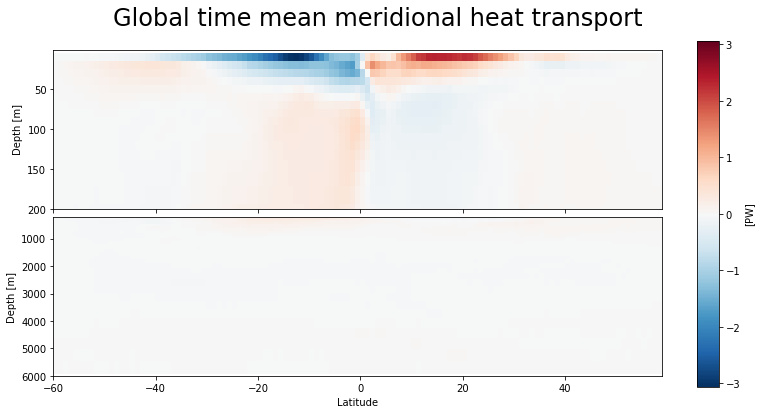

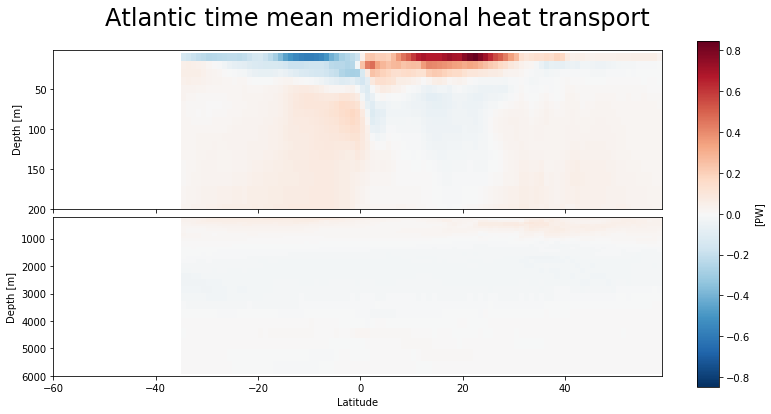

In [26]:
lat_depth_plot(mht,'global_heat_trsp_z','Global')
lat_depth_plot(mht,'atl_heat_trsp_z','Atlantic')

## Exercise: reproduce figure from Ganachaud and Wunsch 2000

![Buckley_MHT](../figures/buckley_mht.png)

Figure from (Buckley and Marshall, 2016), which is adapted from (Ganachaud and Wunsch, 2000).

Note: to do this, you may need to pair latitude masks with those defined through the `get_section_masks` module. An example of this functionality is shown in the next tutorial. 

## References

Buckley, M. W. and Marshall, J. ( 2016), Observations, inferences, and mechanisms of the Atlantic Meridional Overturning Circulation: A review, Rev. Geophys., 54, doi:10.1002/2015RG000493.

Ganachaud, A., & Wunsch, C. (2000). Improved estimates of global ocean circulation, heat transport and mixing from hydrographic data. Nature, 408(6811), 453-7. doi:http://dx.doi.org.ezproxy.lib.utexas.edu/10.1038/35044048